# Deps

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data

In [3]:
df = pd.read_csv("../data/train.csv")
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
df.drop(columns='Id', inplace=True)

# Missing values

In [22]:
missing = df.isna().sum()[df.isna().sum() > 0].to_frame('missing_count')
dtypes = df.dtypes.to_frame('dtype')
result = missing.join(dtypes, rsuffix='_dtype')

result

,missing_count,dtype
LotFrontage,259,float64
Alley,1369,object
MasVnrType,872,object
MasVnrArea,8,float64
BsmtQual,37,object
BsmtCond,37,object
BsmtExposure,38,object
BsmtFinType1,37,object
BsmtFinType2,38,object
Electrical,1,object


# House price distribution

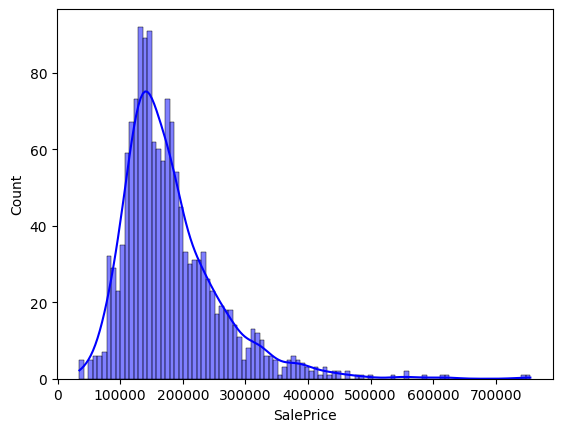

In [10]:
sns.histplot(df['SalePrice'], color='b', bins=100, kde=True);

# Numerical data distribution

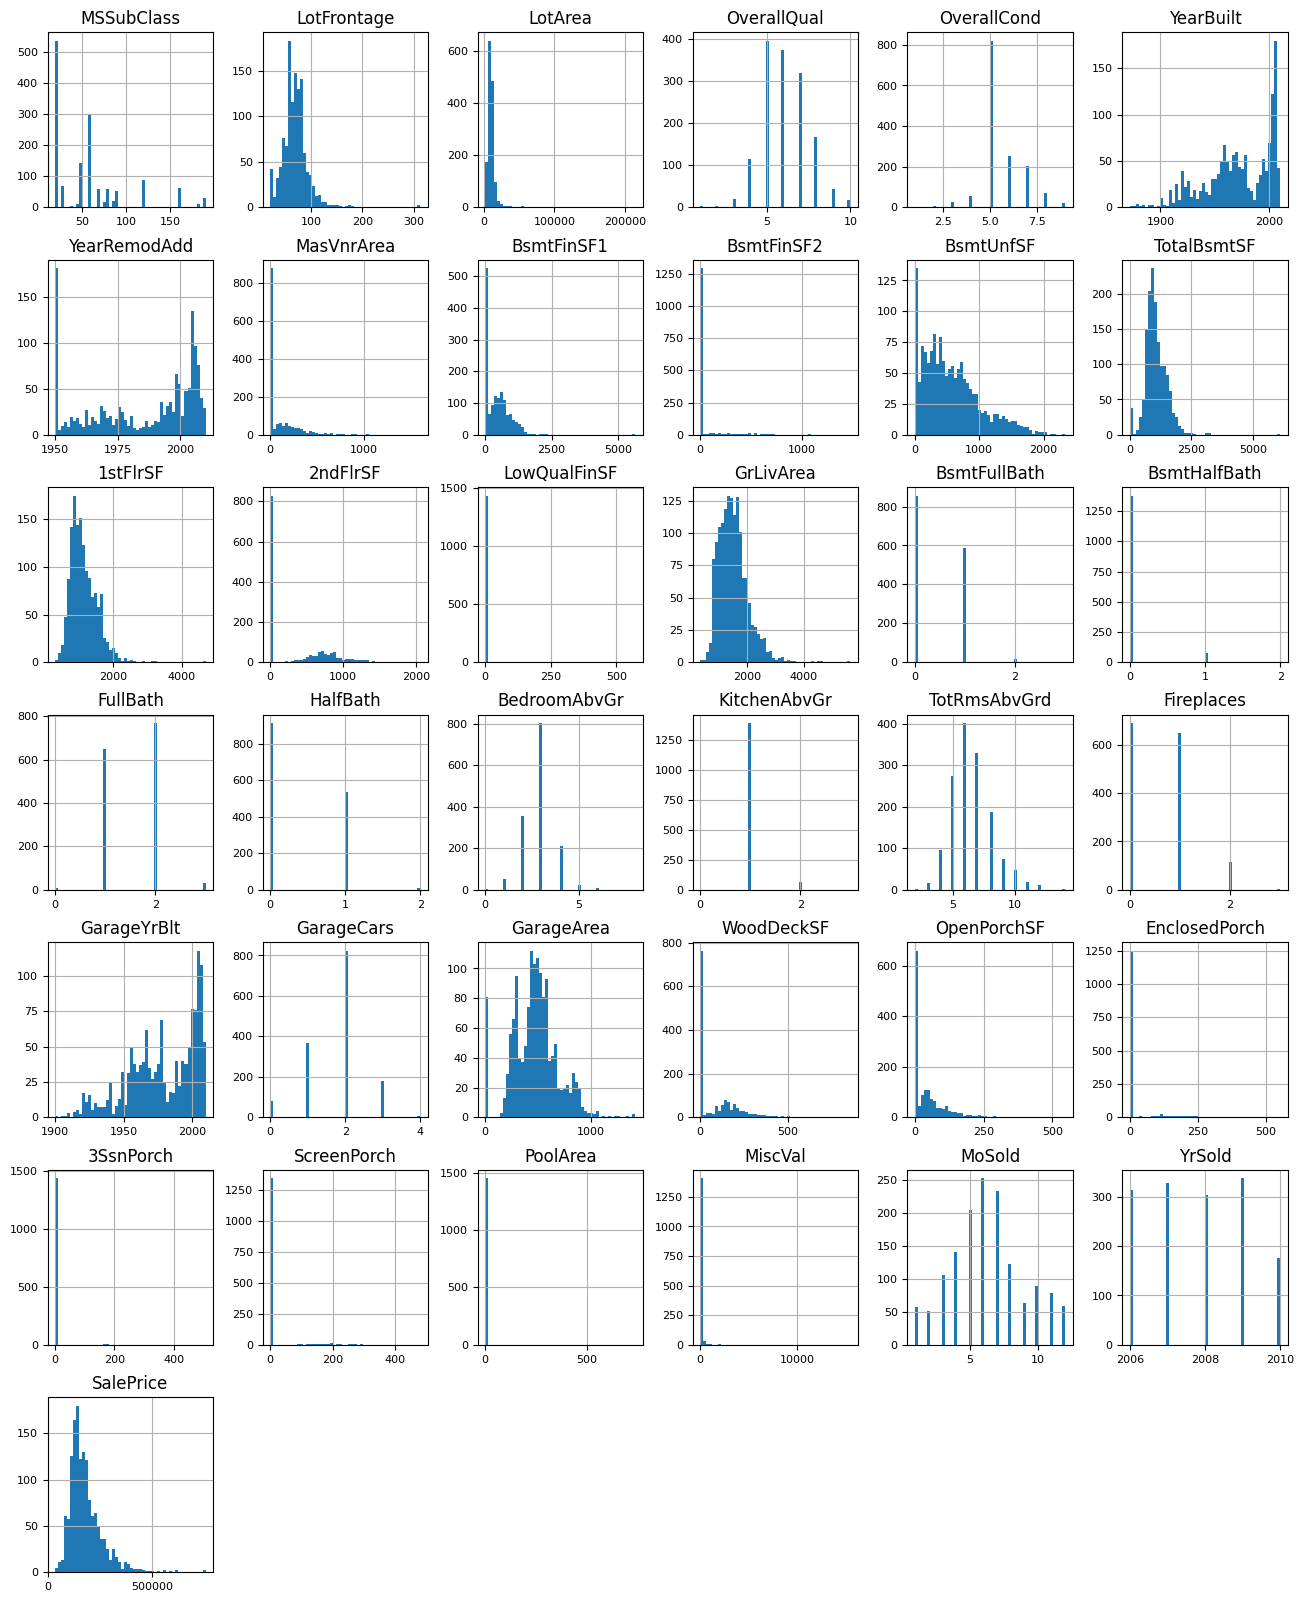

In [17]:
df_num = df.select_dtypes(include = "number")
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

# Feature selection with Lasso

In [23]:
num_cols = df_num.columns
cat_cols = df.select_dtypes(exclude = "number").columns

In [26]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, TargetEncoder

In [32]:
X = df.drop('SalePrice', axis=1)
y = df['SalePrice']

# Separate column types
numerical_cols = X.select_dtypes(include="number").columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# Special case: Some numeric columns are actually categorical (per data description)
categorical_like_numeric = ['MSSubClass', 'MoSold', 'YrSold']
for col in categorical_like_numeric:
    if col in numerical_cols:
        numerical_cols.remove(col)
        categorical_cols.append(col)

# Split categorical by cardinality
threshold = 10
low_card_cols = [col for col in categorical_cols if X[col].nunique() < threshold]
high_card_cols = [col for col in categorical_cols if X[col].nunique() >= threshold]

# Build preprocessing pipeline
preprocessor = ColumnTransformer([
    # Numerical: impute + scale
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), numerical_cols),

    # Low cardinality: impute + one-hot encode
    ('low_cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), low_card_cols),

    # High cardinality: impute + frequency encode
    ('high_cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('target_enc', TargetEncoder())
    ]), high_card_cols)

], remainder='passthrough')

In [33]:
from sklearn.linear_model import LassoCV

model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LassoCV(cv=5, max_iter=10000, random_state=42))
])

model.fit(X, y)

# Access coefficients
coef = model.named_steps['regressor'].coef_
feature_names = model.named_steps['preprocessor'].get_feature_names_out()
importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coef,
    'importance': abs(coef)
}).sort_values('importance', ascending=False)

importance_df.head(10)

/opt/anaconda3/envs/MLOps/lib/python3.11/site-packages/sklearn/model_selection/_split.py:811: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


,feature,coefficient,importance
97,low_cat__RoofMatl_ClyTile,-162374.676491,162374.676491
74,low_cat__Condition2_PosN,-27724.546003,27724.546003
172,low_cat__KitchenQual_Ex,27212.770851,27212.770851
124,low_cat__BsmtQual_Ex,26687.552245,26687.552245
14,num__GrLivArea,26215.072671,26215.072671
2,num__OverallQual,15515.893072,15515.893072
135,low_cat__BsmtExposure_Gd,12750.986458,12750.986458
104,low_cat__RoofMatl_WdShngl,12017.055034,12017.055034
78,low_cat__BldgType_1Fam,11980.727502,11980.727502
235,low_cat__SaleType_New,11554.991881,11554.991881


In [42]:
'low_cat__RoofMatl_ClyTile'.split('__', 1)

['low_cat', 'RoofMatl_ClyTile']

In [ ]:
def get_original_feature(encoded_name):
    """Extract original column name from preprocessed feature name."""
    if '__' in encoded_name:
        prefix, suffix = encoded_name.split('__', 1)

        if '_' in suffix:
            orig_col = suffix.split('_', 1)[0]
            return orig_col

        return suffix
    return encoded_name  # fallback

n_top = 10
top_features = importance_df.head(n_top)['feature']

# Extract original column names
original_cols = []
for feat in top_features:
    orig = get_original_feature(feat)
    if orig not in original_cols:
        original_cols.append(orig)

print("Top N original columns:\n", original_cols)

Top N original columns:
 ['RoofMatl', 'Condition2', 'KitchenQual', 'BsmtQual', 'GrLivArea', 'OverallQual', 'BsmtExposure', 'BldgType', 'SaleType']


# Train XGBRegressor Model with Top 10 Features ONLY

In [46]:
from xgboost import XGBRegressor

In [47]:
X_top = X[original_cols].copy()
X_top.head()

,RoofMatl,Condition2,KitchenQual,BsmtQual,GrLivArea,OverallQual,BsmtExposure,BldgType,SaleType
0,CompShg,Norm,Gd,Gd,1710,7,No,1Fam,WD
1,CompShg,Norm,TA,Gd,1262,6,Gd,1Fam,WD
2,CompShg,Norm,Gd,Gd,1786,7,Mn,1Fam,WD
3,CompShg,Norm,Gd,TA,1717,7,No,1Fam,WD
4,CompShg,Norm,Gd,Gd,2198,8,Av,1Fam,WD


In [48]:
# Separate numerical and categorical in top 10
num_in_top = X_top.select_dtypes(include="number").columns.tolist()
cat_in_top = X_top.select_dtypes(exclude="number").columns.tolist()

preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]), num_in_top),

    ('cat', Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ]), cat_in_top)
], remainder='passthrough')

# Step 4: Create final pipeline with XGBoost
final_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('xgb', XGBRegressor(random_state=42))
])

# Train
final_pipeline.fit(X_top, y)

,steps,"[('preprocessor', ...), ('xgb', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'passthrough'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


# Evaluate Model

In [54]:
from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_error

In [55]:
y_pred = final_pipeline.predict(X_top)

mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)
rmse = root_mean_squared_error(y, y_pred)
mae = mean_absolute_error(y, y_pred)

metrics = {
  'mse': mse,
  'r2': r2,
  'rmse': rmse,
  'mae': mae
}

metrics

{'mse': 161657264.0,
 'r2': 0.9743677377700806,
 'rmse': 12714.451171875,
 'mae': 8781.388671875}

In [56]:
print("📊 Model Performance Summary")
print("----------------------------")
print(f"R² Score:        {metrics['r2']:.4f}")
print(f"RMSE:            ${metrics['rmse']:,.0f}")
print(f"MSE:             ${metrics['mse']:,.0f}")
print(f"MAE:             ${metrics['mae']:,.0f}")

📊 Model Performance Summary
----------------------------
R² Score:        0.9744
RMSE:            $12,714
MSE:             $161,657,264
MAE:             $8,781


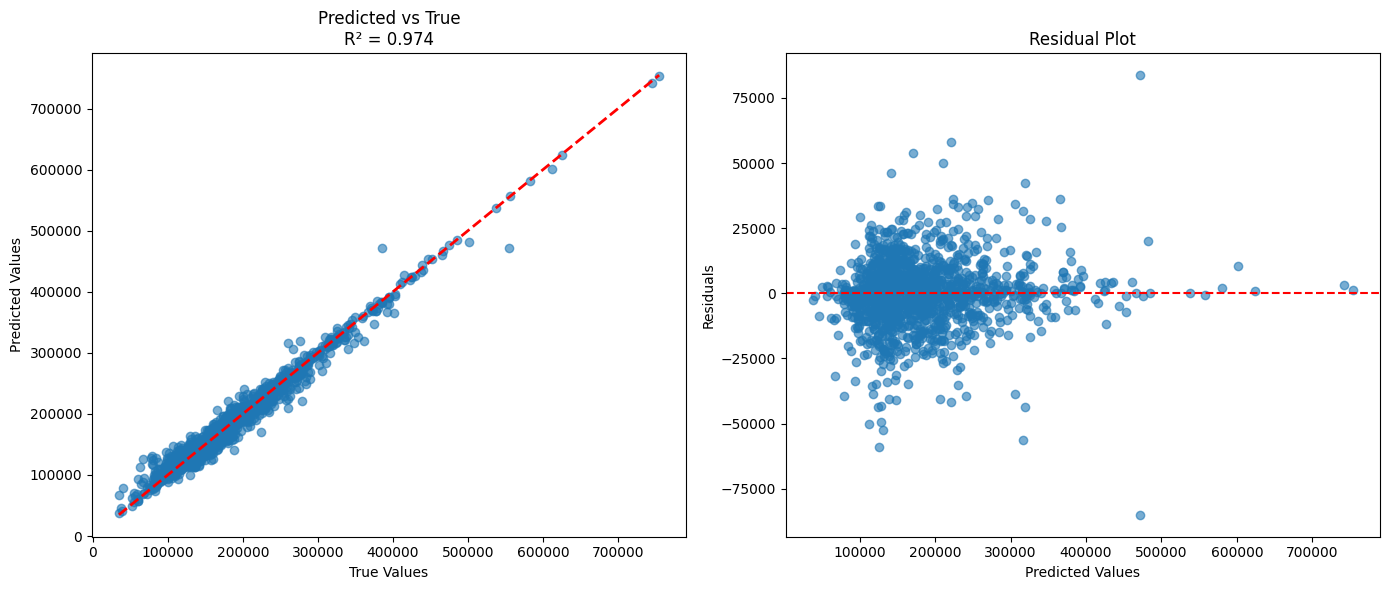

In [52]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Predicted vs True
ax1.scatter(y, y_pred, alpha=0.6)
ax1.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
ax1.set_xlabel('True Values')
ax1.set_ylabel('Predicted Values')
ax1.set_title(f'Predicted vs True\nR² = {r2_score(y, y_pred):.3f}')

# Plot 2: Residuals
residuals = y - y_pred
ax2.scatter(y_pred, residuals, alpha=0.6)
ax2.axhline(y=0, color='r', linestyle='--')
ax2.set_xlabel('Predicted Values')
ax2.set_ylabel('Residuals')
ax2.set_title('Residual Plot')

plt.tight_layout()
plt.show()

In [5]:
import yaml
import pandas as pd
with open("../params.yaml", "r") as f:
  params = yaml.safe_load(f)
train = pd.read_csv('../data/train.csv', usecols=params["selected_features"] + ["SalePrice"])
train.head()

,Condition2,BldgType,OverallQual,RoofMatl,BsmtQual,BsmtExposure,GrLivArea,KitchenQual,SaleType,SalePrice
0,Norm,1Fam,7,CompShg,Gd,No,1710,Gd,WD,208500
1,Norm,1Fam,6,CompShg,Gd,Gd,1262,TA,WD,181500
2,Norm,1Fam,7,CompShg,Gd,Mn,1786,Gd,WD,223500
3,Norm,1Fam,7,CompShg,TA,No,1717,Gd,WD,140000
4,Norm,1Fam,8,CompShg,Gd,Av,2198,Gd,WD,250000


In [11]:
train.dtypes

Condition2      object
BldgType        object
OverallQual      int64
RoofMatl        object
BsmtQual        object
BsmtExposure    object
GrLivArea        int64
KitchenQual     object
SaleType        object
SalePrice        int64
dtype: object